# Using [Microsoft CLAP model](https://ieeexplore.ieee.org/abstract/document/10095889) to perform zeroshot classification on [Environmental Sound Classification 50 dataset](https://github.com/karolpiczak/ESC-50)


Contrastive Language-Audio Pretraining (CLAP) model, connects language and audio by using two encoders and a contrastive learning objective, bringing audio and text descriptions into a joint multimodal space.

Mainstream listening models require labeled audio for training and can only predict the predefined categories. Instead, CLAP model can learn audio concepts from natural language supervision.

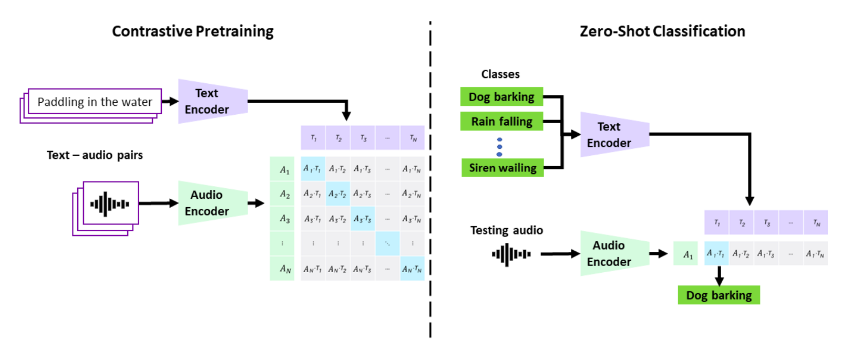


It is characterized by **high accuracy for ESC50 dataset ~ 93.9%.**

To use the model run `pip install msclap`

## Performing zero-shot classification using CLAP

* The CLAP model is initialized with a specified version. Next text embeddings are computed for the provided prompts using the CLAP model. Similarly, audio embeddings are computed for each audio sample in the dataset.

* Similarity Computation: The cosine similarity between audio and text embeddings is computed. This measures how semantically similar the audio content is to the provided prompts.

* Prediction: Based on the computed similarities, predictions are made regarding which class each audio sample belongs to.

* Evaluation: The accuracy of the predictions is evaluated against the true labels of the dataset.

In [2]:
"""
This is an example using CLAP to perform zeroshot
    classification on ESC50 (https://github.com/karolpiczak/ESC-50).
"""

from msclap import CLAP
from esc50_dataset import ESC50
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Load dataset
root_path = "/content/drive/MyDrive/" # Folder where to download ESC-50-master/
dataset = ESC50(root=root_path, download=False) #If download=False code assumes base_folder='ESC-50-master' in esc50_dataset.py
prompt = 'this is the sound of '
y = [prompt + x for x in dataset.classes]

# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=False)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

# Computing audio embeddings
y_preds, y_labels = [], []
for i in tqdm(range(len(dataset))):
    x, _, one_hot_target = dataset.__getitem__(i)
    audio_embeddings = clap_model.get_audio_embeddings([x], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)
    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()
    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


y_labels, y_preds = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
acc = accuracy_score(np.argmax(y_labels, axis=1), np.argmax(y_preds, axis=1))
print('ESC50 Accuracy {}'.format(acc))



645695005it [00:39, 16438460.15it/s]


Loading audio files


2000it [00:00, 17781.55it/s]


CLAP_weights_2023.pth:   0%|          | 0.00/690M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

100%|██████████| 2000/2000 [16:59<00:00,  1.96it/s]

ESC50 Accuracy 0.9385


'\nThe output:\n\nESC50 Accuracy: 93.9%\n\n'

## Examples of zero-shot inference

Two audio samples will be used to demonstrate CLAP zero-shot inferences: *coughing* and *cow mooing* sounds.

Coughing sound is paired with 5 labels: `'coughing','sneezing','drinking sipping', 'breathing', 'brushing teeth'`. Next embedings for the labels and for tha audio files are computed. Then the similarity measure is calculated resulting in correct inference of the audio being a coughing sound with 99,45% certainty.  

In [3]:
import IPython.display as ipd

ipd.Audio("data/audio/coughing_test.wav")

In [4]:
"""
This is an example using CLAP for zero-shot inference.
"""
from msclap import CLAP
import torch.nn.functional as F

# Define classes for zero-shot
# Should be in lower case and can be more than one word
classes = ['coughing','sneezing','drinking sipping', 'breathing', 'brushing teeth']
ground_truth = ['coughing']
# Add prompt
prompt = 'this is a sound of '
class_prompts = [prompt + x for x in classes]
#Load audio files
audio_files = ['data/audio/coughing_test.wav']


# compute text embeddings from natural text
text_embeddings = clap_model.get_text_embeddings(class_prompts)

# compute the audio embeddings from an audio file
audio_embeddings = clap_model.get_audio_embeddings(audio_files, resample=True)

# compute the similarity between audio_embeddings and text_embeddings
similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

similarity = F.softmax(similarity, dim=1)
values, indices = similarity[0].topk(5)

# Print the results
print("Ground Truth: {}".format(ground_truth))
print("Top predictions:\n")
for value, index in zip(values, indices):
    print(f"{classes[index]:>16s}: {100 * value.item():.2f}%")



Ground Truth: ['coughing']
Top predictions:

        coughing: 99.45%
        sneezing: 0.53%
drinking sipping: 0.01%
       breathing: 0.00%
  brushing teeth: 0.00%


Similiarly for cow mooing sound the inference is correct!

In [4]:
import IPython.display as ipd

ipd.Audio("data/audio/cow_test.wav")

In [8]:
# Define classes for zero-shot
# Should be in lower case and can be more than one word
classes = ['cow','horse', 'wind', 'car']
ground_truth = ['cow']
# Add prompt
prompt = 'this is a sound of '
class_prompts = [prompt + x for x in classes]
#Load audio files
audio_files = ['data/audio/cow_test.wav']


# compute text embeddings from natural text
text_embeddings = clap_model.get_text_embeddings(class_prompts)

# compute the audio embeddings from an audio file
audio_embeddings = clap_model.get_audio_embeddings(audio_files, resample=True)

# compute the similarity between audio_embeddings and text_embeddings
similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

similarity = F.softmax(similarity, dim=1)
values, indices = similarity[0].topk(4)

# Print the results
print("Ground Truth: {}".format(ground_truth))
print("Top predictions:\n")
for value, index in zip(values, indices):
    print(f"{classes[index]:>16s}: {100 * value.item():.2f}%")



Ground Truth: ['cow']
Top predictions:

             cow: 99.77%
           horse: 0.23%
            wind: 0.00%
             car: 0.00%


## References
* [Elizalde, B., Deshmukh, S., Ismail, M. A., & Wang, H. (2023). Clap learning audio concepts from natural language supervision. ICASSP 2023 - 2023 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 1–5.](https://doi.org/10.1109/ICASSP49357.2023.10095889)
* [Piczak, K. J. (2015). Esc: Dataset for environmental sound classification. Proceedings of the 23rd ACM International Conference on Multimedia, 1015–1018.](https://doi.org/10.1145/2733373.2806390)